In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

**Q1 Generate scatter plots between each of the features and label. Also compute the correlation
coefficients between each feature-label pair. What do the scatter plots and correlations convey
about the different relationships?**

In [187]:
df = pd.read_csv("../patient_satisfaction.txt", delim_whitespace=True, header = None)
df.columns = ['hospital(y)', 'x1', 'x2','x3']
df.head()

,hospital(y),x1,x2,x3
0,48,50,51,2.3
1,57,36,46,2.3
2,66,40,48,2.2
3,70,41,44,1.8
4,89,28,43,1.8


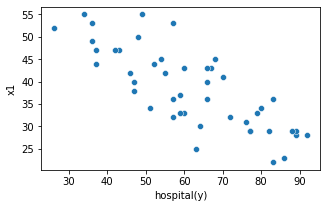

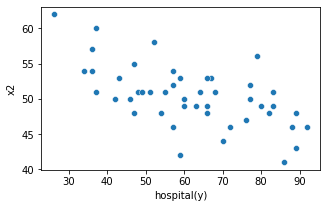

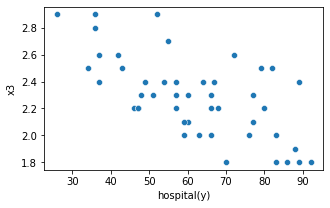

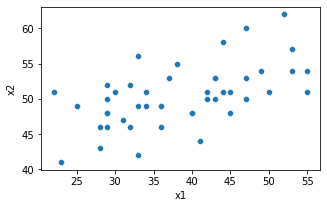

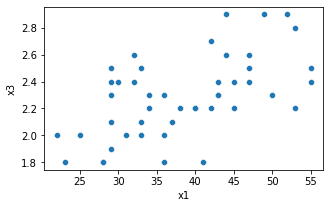

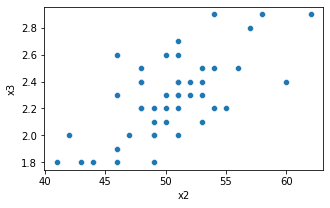

In [188]:
def plot_vars(dframe, var1, var2):
    plt.figure(figsize=(5,3))
    sns.scatterplot(x=var1,y=var2,data=dframe)
    plt.show()

for i, column1 in enumerate(df.columns):
    for j, column2 in enumerate(df.columns):
        if column1 != column2 and j>i:
            plot_vars(df, column1, column2)

In [189]:
df.corr()

,hospital(y),x1,x2,x3
hospital(y),1.000000,-0.786756,-0.602942,-0.644591
x1,-0.786756,1.000000,0.567950,0.569677
x2,-0.602942,0.567950,1.000000,0.670529
x3,-0.644591,0.569677,0.670529,1.000000


In the above correlation coeffiecient dataframe, we see that target variable has maximum correlation with x1, x3, x2 in the order. Whether coefficient is negative or positive, it doesnt matter. We see that all three variables are negatively correlated with the target variable, meaning that target variable decreases on increase in these features.

We also see that these variables also have high correlation among themselves, for example x3 and x2 have correlation value = 0.670529

**Q2 Divide this data into K=10 folds of training and testing sets. Using your own implementations
of batch, stochastic and mini-batch gradient descent, fit a linear regression model using the
training data. Generate plots of the training loss for each iteration and implementation.
Experiment with different values for the learning rate and mini-batch size. Discuss how
you selected the optimal values for the learning rate and mini-batch size. Display the final
regression coefficients for each implementation**

In [190]:
from sklearn.model_selection import KFold

# Plots the test and train errors for each iteration
def plot_train_test_errors(train_errors, test_errors, label):
    n_iterations = [i+1 for i in range(len(train_errors))]
    plt.plot(n_iterations, train_errors, label="train_err")
    plt.plot(n_iterations, test_errors, label="test_err")
    plt.title(label)
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel("Square Error")
    plt.show()

# This function caps the weights, which prevents weights from being too high because of high learning rates.
def cap_weights(weights, cap=10):
    for i,weight in enumerate(weights):
        if abs(weight[0]) > cap:
            weights[i]=cap if weight[0] > 0 else -cap

            
# Calculates mean square error.
def get_rms_error(y_true, y_test):
    error = y_true - y_test
    return (error.T.dot(error) / len(y_true))

def train_batch_regressor(x,y, learning_rate, iterations, x_test, y_test, initial_weight=np.random.randn(4, 1)):
    train_errors = []
    test_errors = []
    weight = np.ndarray.copy(initial_weight)
    
    train_errors.append(get_rms_error(y["hospital(y)"], x.dot(weight)[0]))
    test_errors.append(get_rms_error(y_test["hospital(y)"], x_test.dot(weight)[0]))

    for i in range(iterations):
        gradients = (2 / len(x)) * x.T.dot(x.dot(weight)[0] - y["hospital(y)"])
        weight = weight - learning_rate * gradients.values.reshape(4, 1)
        cap_weights(weight)
        
        train_errors.append(get_rms_error(y["hospital(y)"], x.dot(weight)[0]))
        test_errors.append(get_rms_error(y_test["hospital(y)"], x_test.dot(weight)[0]))
    return weight, train_errors, test_errors

df["bias"] = np.ones(len(df))
weight = np.random.randn(4,1)
x = df.drop(labels=["hospital(y)"], axis=1)
y = df[["hospital(y)"]]
folds = KFold(n_splits=10, random_state=42, shuffle=True)

learning_rates = [0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
iterations = 150
errors={}
for learning_rate in learning_rates:
    errors[str(learning_rate)] = {"train":None, "test":None}
    for train_index, test_index in folds.split(x,y):
        new_weight, train_errors, test_errors = train_batch_regressor(x.iloc[train_index],y.iloc[train_index], learning_rate, iterations, x.iloc[test_index], y.iloc[test_index], weight)
        if errors[str(learning_rate)]["train"] is None:
            errors[str(learning_rate)]["train"] = [0 for x in train_errors]
            errors[str(learning_rate)]["test"] = [0 for x in test_errors]
        errors[str(learning_rate)]["train"] = [x+y for x,y in zip(train_errors, errors[str(learning_rate)]["train"])]
        errors[str(learning_rate)]["test"] = [x+y for x,y in zip(test_errors, errors[str(learning_rate)]["test"])]
        
# Averages the errors across each fold
for key in errors:
    errors[key]["train"] = [x/10 for x in errors[key]["train"]]
    errors[key]["test"] = [x/10 for x in errors[key]["test"]]

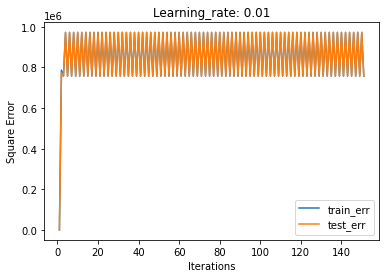

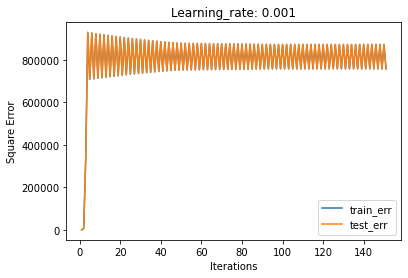

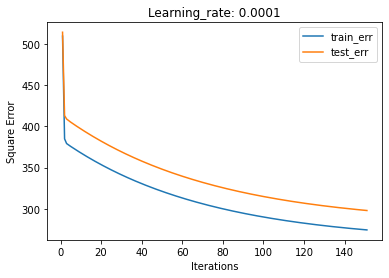

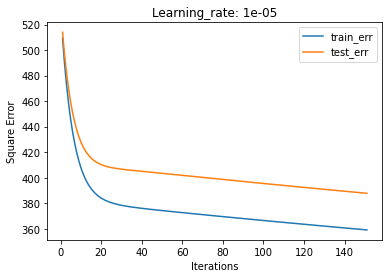

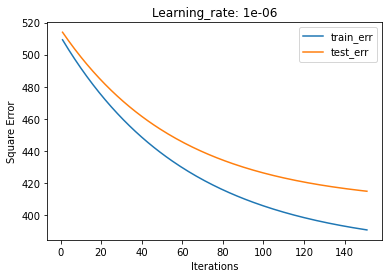

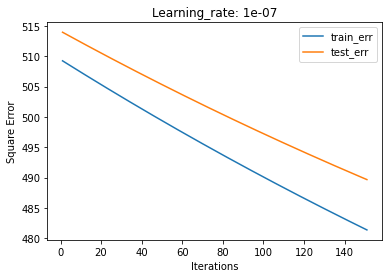

In [191]:
# Plotting the error graphs for batch descent
for key in errors:
    plot_train_test_errors(errors[key]["train"], errors[key]["test"], "Learning_rate: " + key)


A function named cap_weight has been added, which caps the maximum weights of the coeffiecient. This was needed because when learning rate is too high, the weights keep on increasing towards infinite. The weights in this case alternate between positive and negative, while continuously increasing in magnitude. This also makes our square error very large, to make it plottable, we have capped the weights. This problem is also called exploding gradients.

In Batch descent we see that till learning rates 0.001, the learning rate was too high, causing weights to continuously explode. After 0.001 the error reduces with each iteration towards a minima.

For learning rate = 0.0000001, the rate is so slow that it doesnt seem to have reached around the minima. While for other learning rates the error is reaching to a minima.

***We see that the learning rate = 0.0001 works best, because it quickly descends and gives results in less number of iterations while also comparatively reaching better minima***

In [192]:
# Stochastic gradient descent
stochastic_err={}
stochastic_iterations = 50
for learning_rate in learning_rates:
    stochastic_err[str(learning_rate)] = {"test":None, "train": None}
    for train_index, test_index in folds.split(x, y):
        new_weight = np.ndarray.copy(weight)
        for iter in range(stochastic_iterations):
            for row_num in train_index:
                x_i = x.iloc[[row_num]]
                y_i = y.iloc[[row_num]]
                gradients = 2 * x_i.T.dot(x_i.dot(new_weight)[0] - y_i["hospital(y)"])
                new_weight = new_weight - learning_rate * gradients.values.reshape(4,1)
                cap_weights(new_weight)
            if stochastic_err[str(learning_rate)]["test"] is None:
                stochastic_err[str(learning_rate)]["test"] = np.zeros(stochastic_iterations)
                stochastic_err[str(learning_rate)]["train"] = np.zeros(stochastic_iterations)
            test_pred = x.iloc[test_index].dot(new_weight)
            train_pred = x.iloc[train_index].dot(new_weight)
            stochastic_err[str(learning_rate)]["train"][iter] += get_rms_error(y["hospital(y)"].iloc[train_index], train_pred[0])
            stochastic_err[str(learning_rate)]["test"][iter] += get_rms_error(y["hospital(y)"].iloc[test_index], test_pred[0])
for key in stochastic_err:
    stochastic_err[key]["train"] = [x/10 for x in stochastic_err[key]["train"]]
    stochastic_err[key]["test"] = [x/10 for x in stochastic_err[key]["test"]]


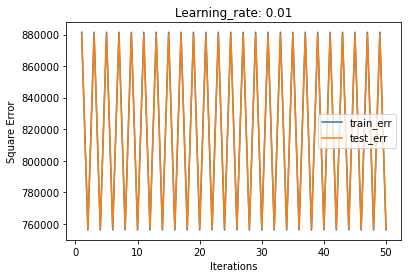

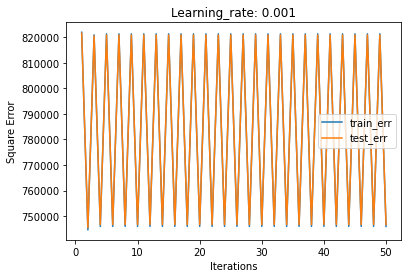

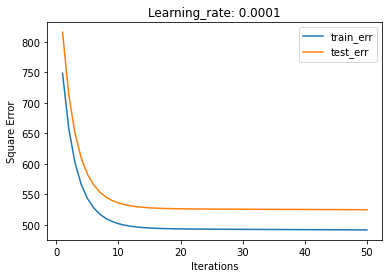

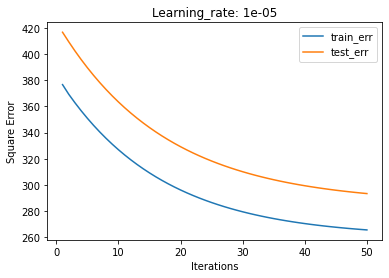

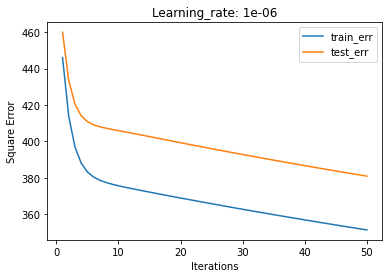

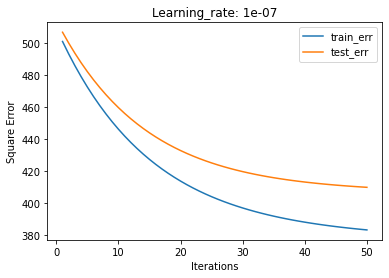

In [193]:
# Plotting the graphs
for key in stochastic_err:
    plot_train_test_errors(stochastic_err[key]["train"], stochastic_err[key]["test"], "Learning_rate: " + key)

The stochastic descent is computatinally expensive, We had to reduce the iterations to 50, to reduce the training time.

Exploding gradient problem also exists here, so we have capped the weights.

With stochastic descent we see that it also results in almost similar plots as that of batch descent. Since we have run 50 iterations of stochastic descent compared to batch descent with 150 iterations, we see that error is slightly higher in stochastic descent.

***With stochastic descent we see that learning rate of 0.00001 works best, as it generalizes well, testing and training error arent far apart while also reaching better minima faster.***

We also observe that with stochastic descent lower learning rates have worked better compared to batch descent.

In [194]:
# Mini batch gradient descent
batch_sizes = [5, 10, 15, 20, 25]
mini_batch_iters = 150
mini_batch_err = {}
for batch_size in batch_sizes:
    mini_batch_err[str(batch_size)] = {}
    for learning_rate in learning_rates:
        mini_batch_err[str(batch_size)][str(learning_rate)] = {"test": np.zeros(mini_batch_iters), "train": np.zeros(mini_batch_iters)}
        for train_index, test_index in folds.split(x, y):
            new_weight = np.ndarray.copy(weight)
            for iter in range(mini_batch_iters):
                for batch_start in range(0, len(train_index), batch_size):
                    batch_end = min(batch_start+batch_size, len(train_index))
                    x_i = x.iloc[train_index[batch_start:batch_end]]
                    y_i = y.iloc[train_index[batch_start:batch_end]]
                    gradients = (2/batch_size) * x_i.T.dot(x_i.dot(new_weight)[0] - y_i["hospital(y)"])
                    new_weight = new_weight - learning_rate * gradients.values.reshape(4,1)
                    cap_weights(new_weight)
                test_pred = x.iloc[test_index].dot(new_weight)
                train_pred = x.iloc[train_index].dot(new_weight)
                mini_batch_err[str(batch_size)][str(learning_rate)]["train"][iter] += get_rms_error(y["hospital(y)"].iloc[train_index], train_pred[0])
                mini_batch_err[str(batch_size)][str(learning_rate)]["test"][iter] += get_rms_error(y["hospital(y)"].iloc[test_index], test_pred[0])

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        err_dict = mini_batch_err[str(batch_size)][str(learning_rate)]
        err_dict["train"] = [x/10 for x in err_dict["train"]]
        err_dict["test"] = [x/10 for x in err_dict["test"]]

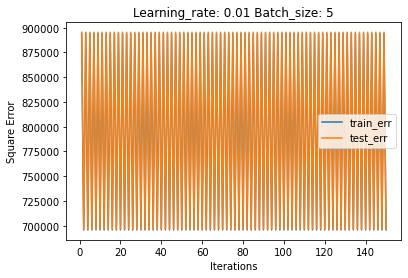

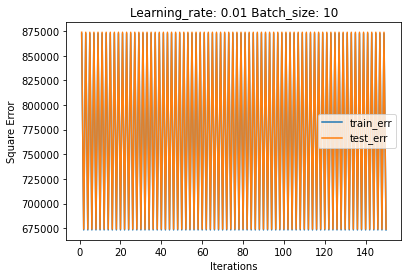

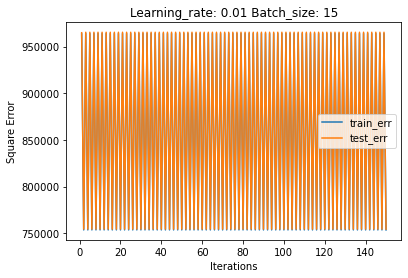

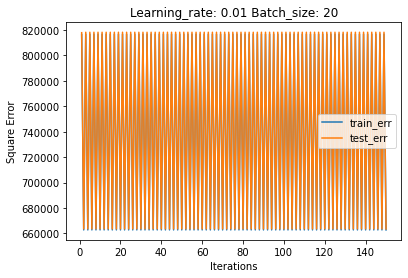

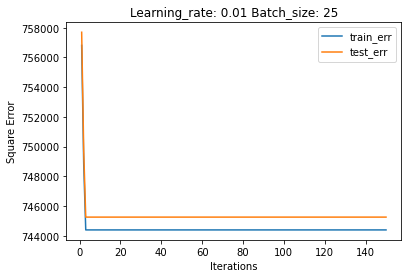

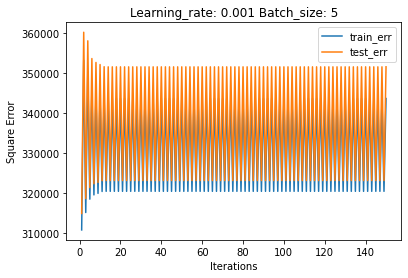

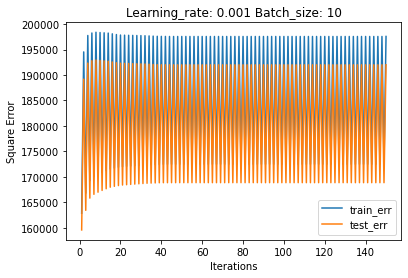

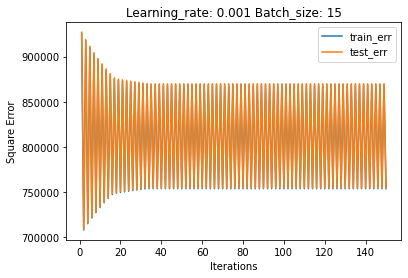

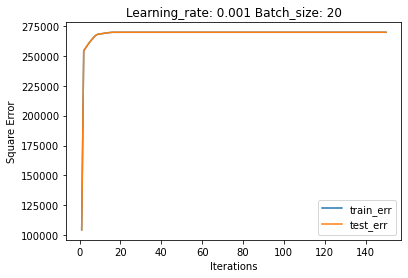

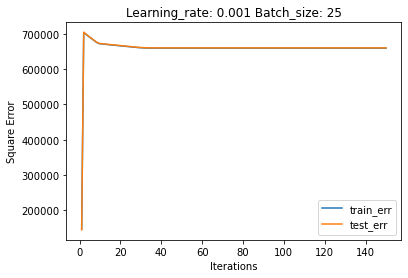

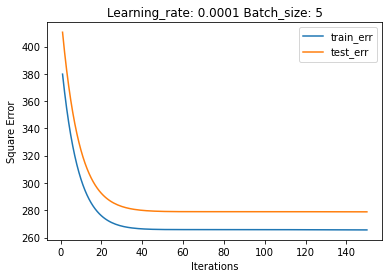

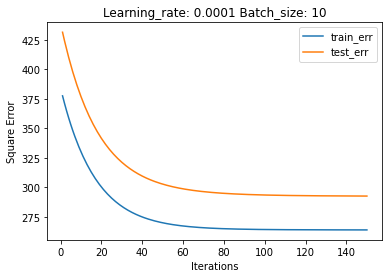

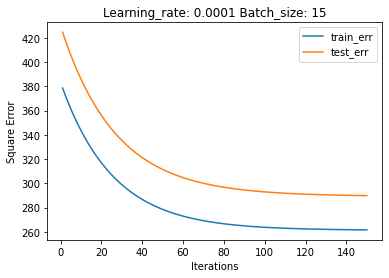

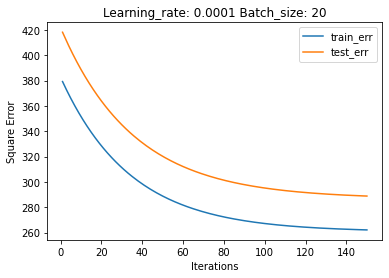

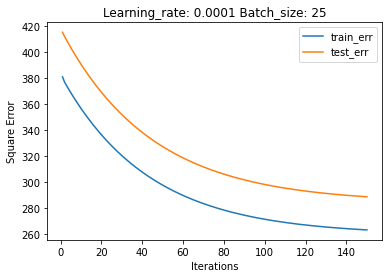

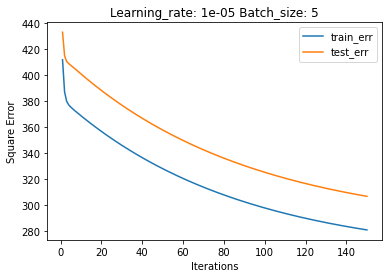

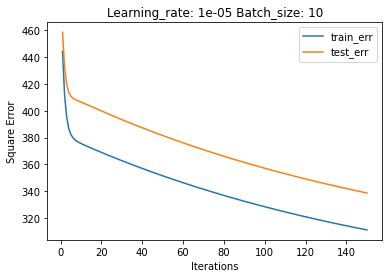

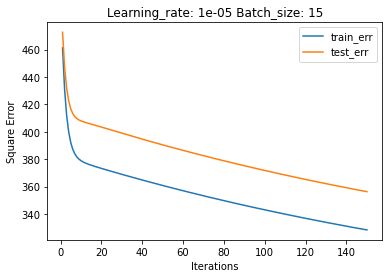

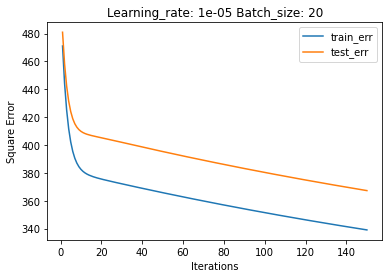

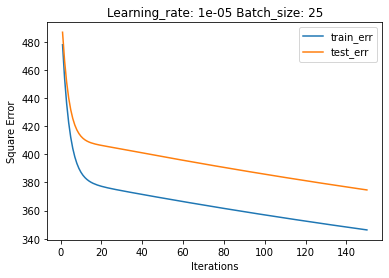

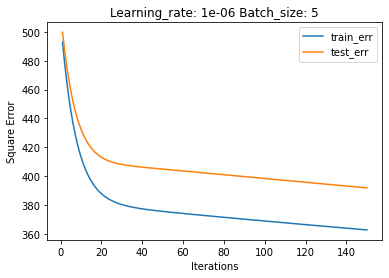

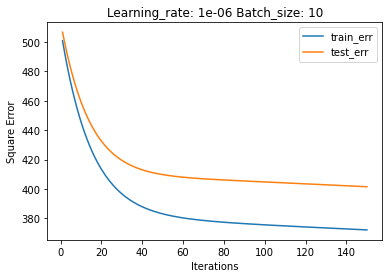

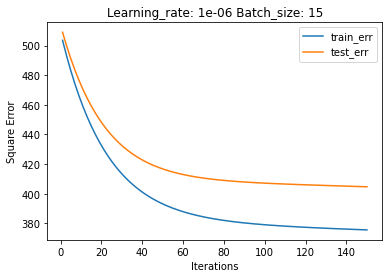

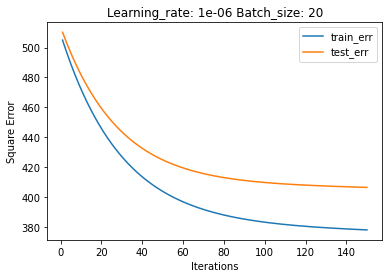

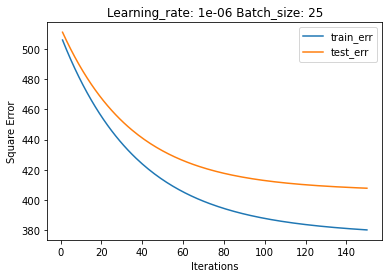

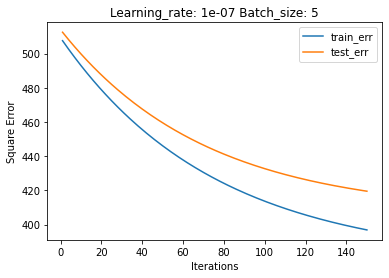

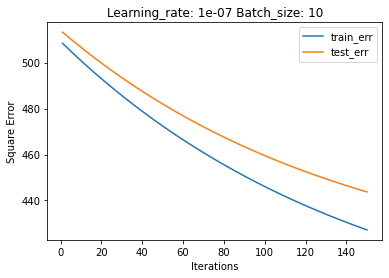

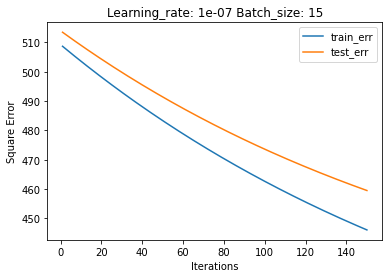

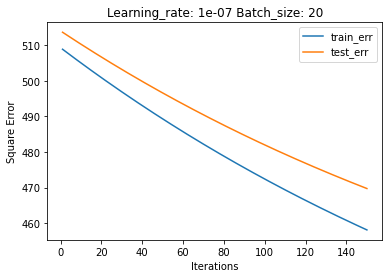

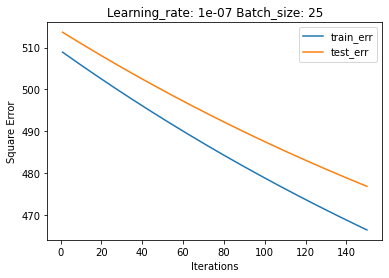

In [195]:
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        err_dict = mini_batch_err[str(batch_size)][str(learning_rate)]
        plot_train_test_errors(err_dict["train"], err_dict["test"], "Learning_rate: " + str(learning_rate) + " Batch_size: " + str(batch_size))

For mini-batch descent, we see that with learning rate = 0.0001, gradients stop exploding.

For learning_rate 0.0001, all the batches have worked in almost similar way and the minimum training and testing errors are also very similar. which is aroun 270-320.

With learning_rate 0.00001, all the batches are similar in performace. In such a case we can choose a higher batch size which is computationally not taxing. We also observe that it generalizes well. However learning rate = 0.0001 reaches minima faster.

With learning rate: 0.000001, all the batches show similar performance. Although it takes even more time to reach minima.

With learning rate: 0.0000001, all the batches are similar. and seem to not have reached minima as it is still descending faster. This is an indication of low learning rate.

Best learning rate for batch descent : 0.0001
Best learning rate for stochastic descent : 0.0001
Best learning rate for mini batch descent : 0.0001

At the learning rate = 0.0001 the descents reach minima faster without exploding the gradients. So this also makes our training process faster.

The least training minima is reached by mini batch descent for our dataset for learning rate: 0.0001 and batch size = 5. While the errors for other descents are also not far away from this and are very similar.

**Q3: Once trained, use the testing data and mean-square error to evaluate performance. Which
approach performed best? Why?**

In linear descent for each of the Batch, stochastic, mini-batch; we have plotted the test errors and training errors.
We observe that all in most case learning rate of 0.0001 works best. This learning rate is able to descent faster and approaches minima in fewer iterations, while also being safe from the exploding gradient problem. 

As for the batch size we see that batch size doesnt have major impact on the performance of the model. However a lower batch size takes longer to train. In such a case, we can choose a maximum batch size which doesnt overload the ram. For our case we can choose a max size of entire batch as there are only 45 data points.

Among batch, stochastic, mini-batch; we see that all the descents yield the minimum error of almost the same value which is around ~300. For our case since the error is similar, we can choose the algorithm which is faster in general, which is batch descent.

So chosen learning rate: 0.0001 and batch size: entire batch, as it is faster and size of 40 is still processable in the memory.